In [157]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dota2_versions.csv
/kaggle/input/dota2_matches_PREVIEW.csv
/kaggle/input/dota2_matches.parquet


In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [159]:
dir_path = '../input/'
matches_path = dir_path + 'dota2_matches.parquet'
versions_path = dir_path + 'dota2_versions.csv'

In [160]:
matches = pd.read_parquet(matches_path, engine='pyarrow')

In [161]:
THRESHOLD_DATE = '2024-01-01'
matches = matches[matches.match_start_date_time < THRESHOLD_DATE]
matches

,league,league_id,league_tier,league_start_date_time,league_end_date_time,league_region,series_id,series_type,match_id,match_start_date_time,...,dire_player_5_hero_id,dire_player_5_hero,dire_player_5_position,dire_player_5_lane,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,game_version_id
9059,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515605198,2023-12-31 23:36:35,...,109,Terrorblade,POSITION_1,SAFE_LANE,CORE,2,4,5,16288,170
9060,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515575705,2023-12-31 22:52:28,...,69,Doom,POSITION_3,OFF_LANE,CORE,5,8,18,12976,170
9061,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515557910,2023-12-31 22:27:49,...,69,Doom,POSITION_4,OFF_LANE,LIGHT_SUPPORT,5,3,18,15148,170
9062,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515528762,2023-12-31 21:47:39,...,46,Templar Assassin,POSITION_1,SAFE_LANE,CORE,8,6,4,26130,170
9063,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515510207,2023-12-31 21:23:26,...,31,Lich,POSITION_5,SAFE_LANE,HARD_SUPPORT,5,10,17,20447,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177373,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002746,BEST_OF_ONE,7472,2011-08-02 00:00:00,...,58,Enchantress,<NA>,<NA>,<NA>,14,3,13,11513,11
177374,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002747,BEST_OF_ONE,4464,2011-06-26 00:00:00,...,35,Sniper,<NA>,<NA>,<NA>,6,4,8,4555,8
177375,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002748,BEST_OF_ONE,4081,2011-06-20 00:00:00,...,15,Razor,<NA>,<NA>,<NA>,4,7,1,6145,8
177376,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002749,BEST_OF_ONE,4067,2011-06-19 00:00:00,...,29,Tidehunter,<NA>,<NA>,<NA>,7,3,14,11637,8


## Missing Values

In [162]:
winner_na = matches.winner_id.isna()
radiant_na = matches.radiant_team_id.isna()
dire_na = matches.dire_team_id.isna()

len_init = len(matches)

matches = matches[~(winner_na | radiant_na | dire_na)].copy()
print(f'Missing values: {(len_init - len(matches)) / len_init * 100:.2f}%')

Missing values: 1.03%


In [163]:
print(f'Missing values of the whole dataframe: {matches.isna().sum().sum()}')
print(f'Fraction of missed values: {matches.isna().sum().sum() / (matches.shape[0] * matches.shape[1])}')
print(f'Fraction of matches that have at least 1 missing value: {(matches.isna().sum(1) > 0).mean()}')

Missing values of the whole dataframe: 2180460
Fraction of missed values: 0.10068474269162198
Fraction of matches that have at least 1 missing value: 0.7278299026934875


In [164]:
matches['year_month'] = matches.match_start_date_time.dt.to_period('M')

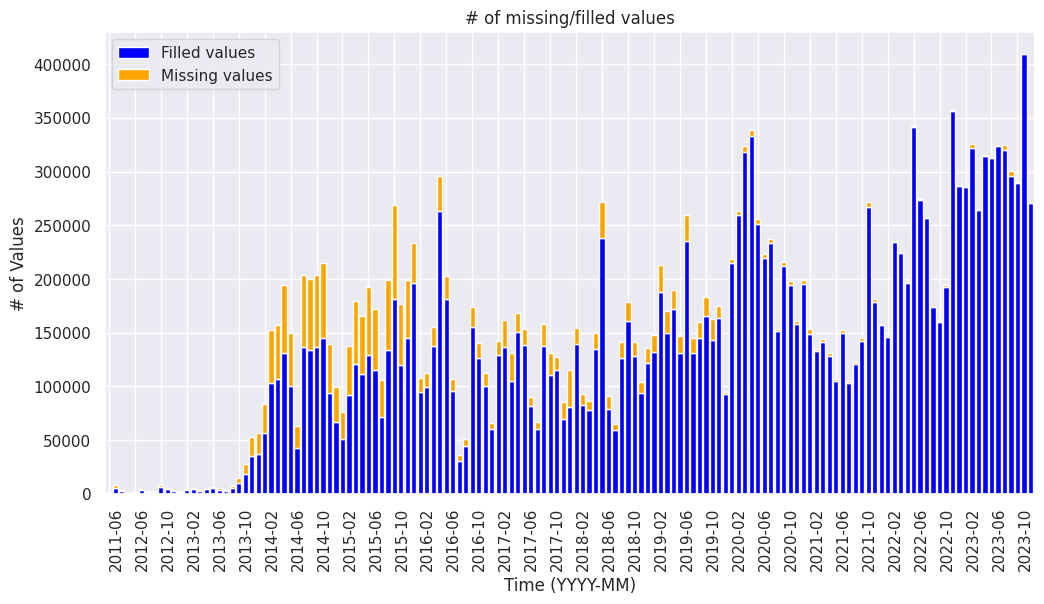

In [165]:
monthly_valid_values = (~matches.isna()).groupby(matches.year_month).sum().sum(1)
monthly_missing_values = matches.isna().groupby(matches['year_month']).sum().sum(1)

plt.figure(figsize=(12, 6))

valid_label = 'Filled values'
missing_label = 'Missing values'
monthly_valid_values.plot(kind='bar', width=0.8, color='blue', label=valid_label)
monthly_missing_values.plot(kind='bar', bottom=monthly_valid_values, width=0.8,
                            color='orange', label=missing_label)
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('# of Values')
plt.title('# of missing/filled values')
plt.legend()

xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks[::4])
plt.gca().set_xticklabels(monthly_missing_values.index[::4].strftime('%Y-%m'), rotation=90, ha='left')

plt.show()

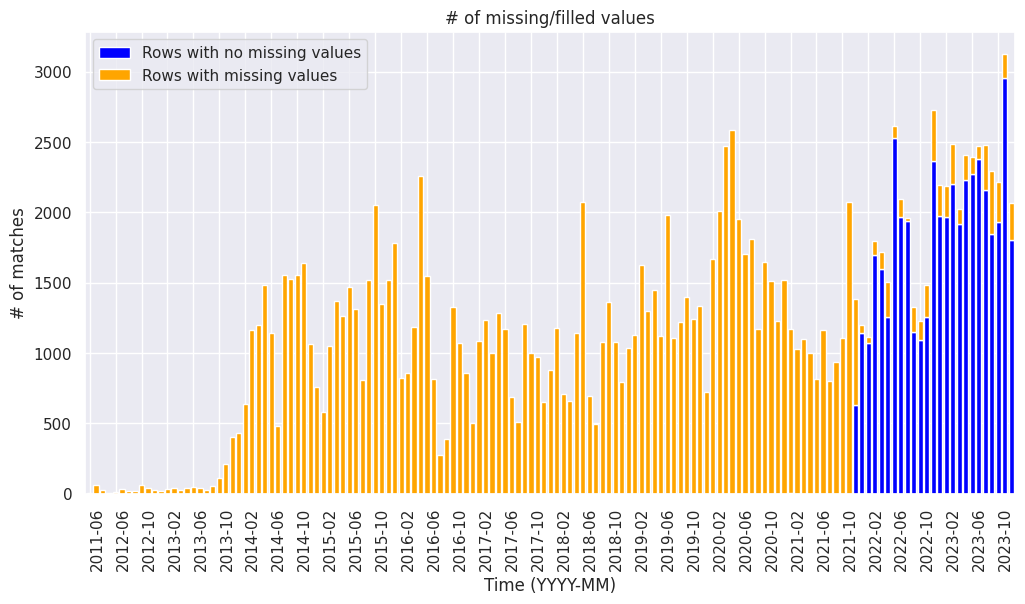

In [166]:
all_rows_per_month = matches.groupby('year_month').size()
corrupted_rows_per_month = matches[matches.isna().sum(1) > 0].groupby('year_month').size()
corrupted_rows_per_month = corrupted_rows_per_month.reindex(all_rows_per_month.index, fill_value=0)
complete_rows_per_month = all_rows_per_month.sub(corrupted_rows_per_month, fill_value=0)

complete_label = 'Rows with no missing values'
corrupted_label = 'Rows with missing values'

plt.figure(figsize=(12, 6))
complete_rows_per_month.plot(kind='bar', width=0.8, color='blue', label=complete_label)
corrupted_rows_per_month.plot(kind='bar', bottom=complete_rows_per_month, width=0.8,
                             color='orange', label=corrupted_label)

plt.xlabel('Time (YYYY-MM)')
plt.ylabel('# of matches')
plt.title('# of missing/filled values')
plt.legend()

xticks = plt.gca().get_xticks()
plt.gca().set_xticks(xticks[::4])
plt.gca().set_xticklabels(monthly_missing_values.index[::4].strftime('%Y-%m'), rotation=90, ha='left')

plt.show()


In [167]:
print('Features that do not have any missing values:')
matches.columns[matches.isna().sum(0) == 0].tolist()

Features that do not have any missing values:


['league',
 'league_id',
 'league_tier',
 'series_id',
 'series_type',
 'match_id',
 'match_start_date_time',
 'match_duration_seconds',
 'radiant_team_id',
 'dire_team_id',
 'winner_id',
 'radiant_player_1_hero_id',
 'radiant_player_1_kills',
 'radiant_player_1_deaths',
 'radiant_player_1_assists',
 'year_month']

In [168]:
matches.columns[matches[matches.match_start_date_time < '2021-01-01'].isna().mean() == 1]

Index(['radiant_kills', 'dire_kills'], dtype='object')

In [169]:
radiant_kills_feats = [f'radiant_player_{i}_kills' for i in range(1, 6)]
matches['radiant_kills'] = matches[radiant_kills_feats].sum(1)
dire_kills_feats = [f'dire_player_{i}_kills' for i in range(1, 6)]
matches['dire_kills'] = matches[dire_kills_feats].sum(1)
matches['total_kills'] = matches.radiant_kills + matches.dire_kills

In [170]:
matches['total_kills']

9059       55
9060       59
9061       43
9062       57
9063       68
         ... 
177373     66
177374    101
177375     44
177376     60
177377     67
Name: total_kills, Length: 166587, dtype: int16[pyarrow]

## Match duration

In [171]:
matches['match_duration_minutes'] = matches.match_duration_seconds / 60
matches.match_duration_minutes.describe()

count     166587.0
mean     34.469709
std      11.289517
min            0.0
25%      26.766667
50%          33.15
75%      40.933333
max         289.45
Name: match_duration_minutes, dtype: double[pyarrow]

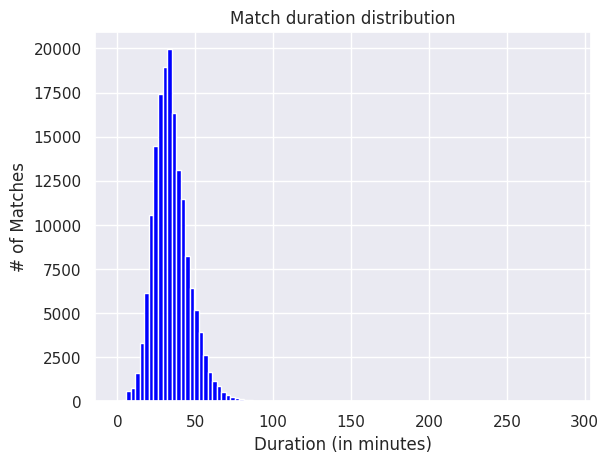

In [172]:
plt.hist(matches.match_duration_minutes, bins=100, color='blue')

plt.title('Match duration distribution')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches')
plt.show()

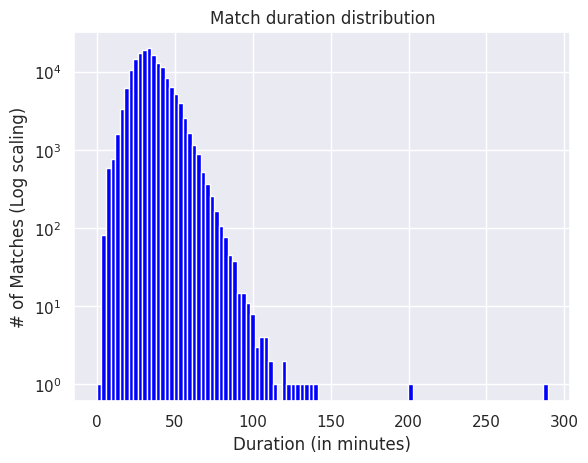

In [173]:
plt.hist(matches.match_duration_minutes, bins=100, color='blue')

plt.title('Match duration distribution')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches (Log scaling)')
plt.yscale('log')
plt.show()

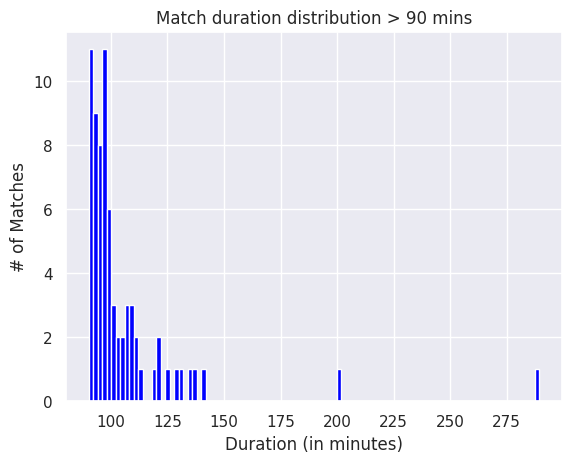

In [174]:
plt.hist(matches[matches.match_duration_minutes >= 90].match_duration_minutes,
         bins=100, color='blue')

plt.title('Match duration distribution > 90 mins')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches')
plt.show()

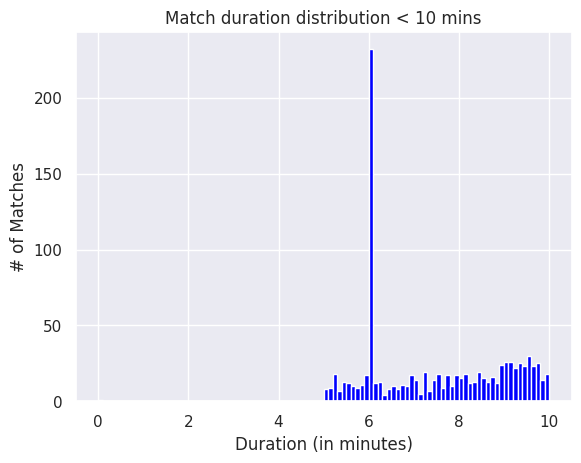

In [175]:
plt.hist(matches[matches.match_duration_minutes <= 10].match_duration_minutes,
         bins=100, color='blue')

plt.title('Match duration distribution < 10 mins')
plt.xlabel('Duration (in minutes)')
plt.ylabel('# of Matches')
plt.show()

In [176]:
print("Anomaly detected")
print(matches[matches.match_duration_minutes <= 10].match_duration_minutes.value_counts())


Anomaly detected
match_duration_minutes
6.0         212
9.133333     10
8.45          7
9.366667      7
9.016667      7
           ... 
6.066667      1
5.85          1
9.2           1
7.633333      1
9.9           1
Name: count, Length: 266, dtype: int64[pyarrow]


In [177]:
matches['radiant_win'] = (matches.winner_id == matches.radiant_team_id)
matches_6_mins = matches[matches.match_duration_minutes == 6]

print(f'Radiant win rate for 6-min long matches : {round(matches_6_mins.radiant_win.mean()*100,2)} %')
print(f'Radiant win rate for all matches : {round(matches.radiant_win.mean()*100,2)} %')

Radiant win rate for 6-min long matches : 4.72 %
Radiant win rate for all matches : 51.19 %


## Net Worth vs Duration

In [178]:

common_features = [col for col in matches.columns if not any(col.startswith(prefix) for prefix in ['radiant_player_', 'dire_player_'])]


player_dfs = []


for i in range(1, 6):
    for team in ['radiant', 'dire']:

        player_cols = [col for col in matches.columns if col.startswith(f"{team}_player_{i}_")]

        selected_columns = common_features + player_cols

        temp_df = matches[selected_columns].copy()

        temp_df.columns = [col.replace(f"{team}_player_{i}_", '') if col.startswith(f"{team}_player_{i}_") else col for col in temp_df.columns]

        temp_df['team'] = team

        temp_df['position'] = temp_df.position.apply(lambda s: int(s[-1]) if pd.notna(s) and s != '' else pd.NA)
        temp_df['win'] = temp_df.radiant_win if team == 'radiant' else ~temp_df.radiant_win
        temp_df['win'] = temp_df.win.astype(bool)

        player_dfs.append(temp_df)


players = pd.concat(player_dfs, ignore_index=True)

players

,league,league_id,league_tier,league_start_date_time,league_end_date_time,league_region,series_id,series_type,match_id,match_start_date_time,...,hero,position,lane,role,kills,deaths,assists,networth,team,win
0,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515605198,2023-12-31 23:36:35,...,Mars,3,OFF_LANE,CORE,10,3,16,17351,radiant,True
1,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515575705,2023-12-31 22:52:28,...,Earthshaker,2,MID_LANE,CORE,8,7,3,16367,radiant,False
2,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515557910,2023-12-31 22:27:49,...,Terrorblade,1,SAFE_LANE,CORE,0,5,6,15392,radiant,False
3,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515528762,2023-12-31 21:47:39,...,Razor,2,MID_LANE,CORE,5,5,6,25269,radiant,False
4,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515510207,2023-12-31 21:23:26,...,Luna,1,SAFE_LANE,CORE,3,7,8,25924,radiant,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665865,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002746,BEST_OF_ONE,7472,2011-08-02 00:00:00,...,Enchantress,<NA>,<NA>,<NA>,14,3,13,11513,dire,True
1665866,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002747,BEST_OF_ONE,4464,2011-06-26 00:00:00,...,Sniper,<NA>,<NA>,<NA>,6,4,8,4555,dire,True
1665867,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002748,BEST_OF_ONE,4081,2011-06-20 00:00:00,...,Razor,<NA>,<NA>,<NA>,4,7,1,6145,dire,False
1665868,The Internal,65000,PROFESSIONAL,2013-11-25 00:00:00,NaT,UNSET,100002749,BEST_OF_ONE,4067,2011-06-19 00:00:00,...,Tidehunter,<NA>,<NA>,<NA>,7,3,14,11637,dire,True


In [179]:
[col for col in
matches.columns[matches[matches.match_start_date_time >= '2020-01-01'].isna().sum(0) == 0]
if col.endswith('networth')
]

['radiant_player_1_networth',
 'radiant_player_2_networth',
 'radiant_player_3_networth',
 'radiant_player_4_networth',
 'radiant_player_5_networth',
 'dire_player_1_networth',
 'dire_player_2_networth',
 'dire_player_3_networth',
 'dire_player_4_networth',
 'dire_player_5_networth']

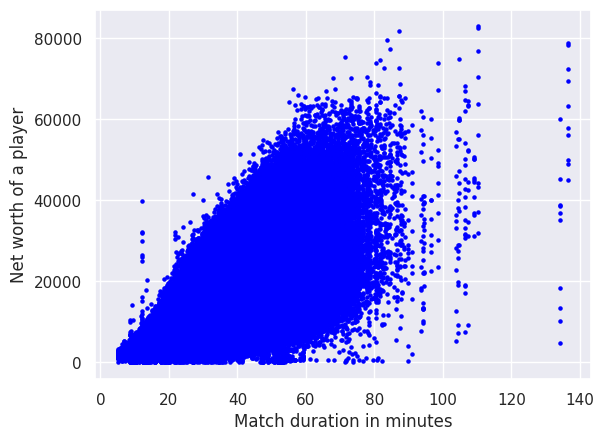

In [180]:
plt.scatter(players.match_duration_minutes, players.networth, color='blue',
           s=5)

plt.xlabel('Match duration in minutes')
plt.ylabel('Net worth of a player')
plt.show()

#### Too dense, we need a subset

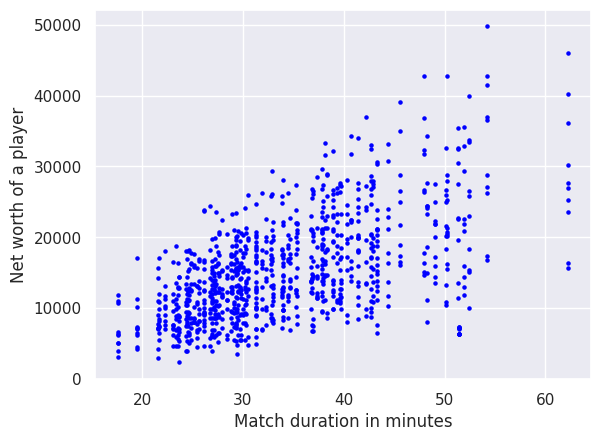

In [181]:
players_subset = players[players.match_start_date_time >= '2023-12-30']
plt.scatter(players_subset.match_duration_minutes,players_subset.networth, color='blue',
           s=5)

plt.xlabel('Match duration in minutes')
plt.ylabel('Net worth of a player')
plt.show()

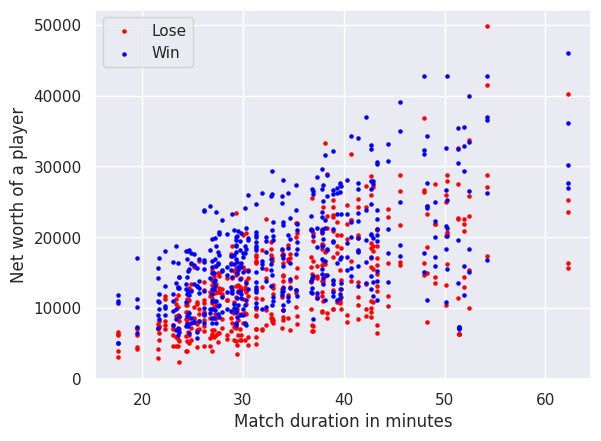

In [182]:
colors = {True: 'blue', False: 'red'}
labels = {True: 'Win', False: 'Lose'}

for status, data in players_subset.groupby('win'):
    plt.scatter(data.match_duration_minutes, data.networth,
               color=colors[status], label=labels[status], s=5)

plt.xlabel('Match duration in minutes')
plt.ylabel('Net worth of a player')
plt.legend()

plt.show()

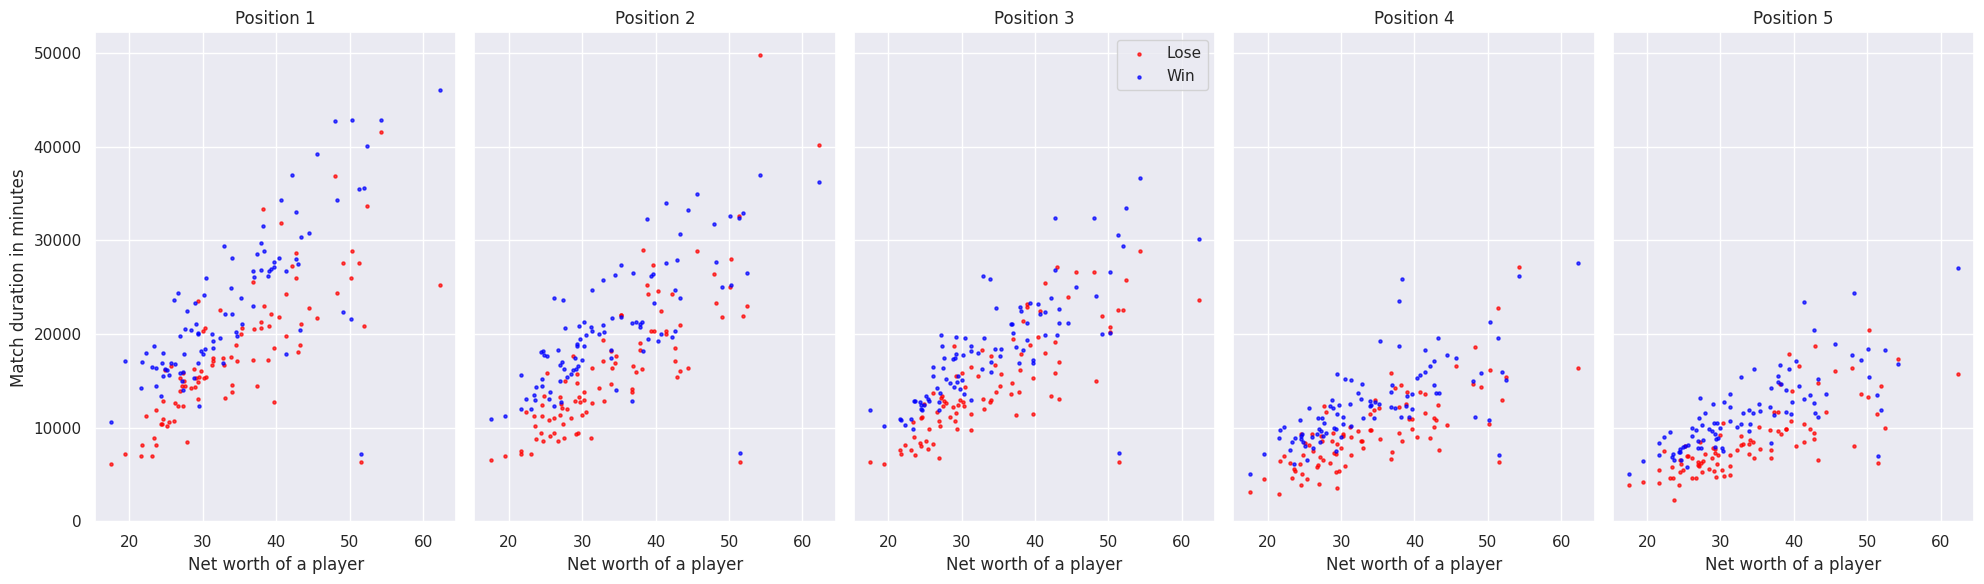

In [183]:
fig, axs = plt.subplots(1, 5, figsize=(20, 6), sharey=True)  
colors_win_lose = {True: 'blue', False: 'red'}  

for position in range(1, 6):
    ax = axs[position-1]
    for win, data in players_subset[players_subset['position'] == position].groupby('win'):
        ax.scatter(data.match_duration_minutes, data.networth,
                   color=colors_win_lose[win], label=f'{"Win" if win else "Lose"}', s=5, alpha=0.7)
    ax.set_title(f'Position {position}')
    if position == 1:
        ax.set_ylabel('Match duration in minutes')
    ax.set_xlabel('Net worth of a player')
    if position == 3:  
        ax.legend()

plt.tight_layout()
plt.show()

## Feature Encoding

In [184]:
missing_values_count = matches.isna().sum()
features_with_most_missing_values = missing_values_count.sort_values(ascending=False)
features_with_most_missing_values

radiant_player_2_networth    80374
radiant_player_3_networth    80374
dire_player_3_networth       80374
radiant_player_1_networth    80374
radiant_player_4_networth    80374
                             ...  
dire_kills                       0
radiant_player_1_hero_id         0
radiant_player_1_kills           0
radiant_player_1_deaths          0
radiant_win                      0
Length: 134, dtype: int64

In [185]:
matches = matches.dropna()
matches

,league,league_id,league_tier,league_start_date_time,league_end_date_time,league_region,series_id,series_type,match_id,match_start_date_time,...,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,game_version_id,year_month,total_kills,match_duration_minutes,radiant_win
9059,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515605198,2023-12-31 23:36:35,...,CORE,2,4,5,16288,170,2023-12,55,28.783333,True
9060,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515575705,2023-12-31 22:52:28,...,CORE,5,8,18,12976,170,2023-12,59,31.333333,False
9061,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515557910,2023-12-31 22:27:49,...,LIGHT_SUPPORT,5,3,18,15148,170,2023-12,43,30.483333,False
9062,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515528762,2023-12-31 21:47:39,...,CORE,8,6,4,26130,170,2023-12,57,38.883333,False
9063,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515510207,2023-12-31 21:23:26,...,HARD_SUPPORT,5,10,17,20447,170,2023-12,68,42.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112868,Russian Pro League,8069,PROFESSIONAL,2018-06-04 00:00:00,2018-06-30 00:00:00,CIS,246056,BEST_OF_THREE,4129856028,2018-09-21 00:00:00,...,CORE,1,7,7,3392,99,2018-09,60,27.85,True
113327,DOTA 2 INDONESIA ONLINE TOURNEY by Maxmund 8,9578,PROFESSIONAL,2018-06-06 00:00:00,2018-06-10 00:00:00,SEA,101534646,BEST_OF_ONE,4117124436,2018-09-14 00:00:00,...,CORE,5,0,4,9018,99,2018-09,27,18.616667,False
117380,ESL India Premiership - 2017 Edition,5407,PROFESSIONAL,2017-05-10 00:00:00,2017-12-22 00:00:00,SEA,101532648,BEST_OF_ONE,3901011325,2018-05-19 00:00:00,...,CORE,7,13,9,10303,92,2018-05,81,36.4,True
117749,NON STOP Energy League,9971,PROFESSIONAL,2018-05-12 00:00:00,2018-06-24 00:00:00,EUROPE,101532596,BEST_OF_ONE,3887809621,2018-05-13 00:00:00,...,HARD_SUPPORT,1,8,3,3778,92,2018-05,37,12.183333,True


In [186]:
from collections import defaultdict
empty_strs = defaultdict(int)
for column in matches.columns:
    if matches[column].dtype == 'string[pyarrow]' and '' in matches[column].unique():
        empty_strs[column]+=1
    
print(f"Columns that have empty string '' : {empty_strs.keys()}")

Columns that have empty string '' : dict_keys(['radiant_team_name', 'dire_team_name', 'radiant_player_1_position', 'radiant_player_1_lane', 'radiant_player_1_role', 'radiant_player_2_position', 'radiant_player_2_lane', 'radiant_player_2_role', 'radiant_player_3_position', 'radiant_player_3_lane', 'radiant_player_3_role', 'radiant_player_4_position', 'radiant_player_4_lane', 'radiant_player_4_role', 'radiant_player_5_position', 'radiant_player_5_lane', 'radiant_player_5_role', 'dire_player_1_position', 'dire_player_1_lane', 'dire_player_1_role', 'dire_player_2_position', 'dire_player_2_lane', 'dire_player_2_role', 'dire_player_3_position', 'dire_player_3_lane', 'dire_player_3_role', 'dire_player_4_position', 'dire_player_4_lane', 'dire_player_4_role', 'dire_player_5_position', 'dire_player_5_lane', 'dire_player_5_role'])


In [187]:
matches = matches[matches != ''].dropna()
matches

,league,league_id,league_tier,league_start_date_time,league_end_date_time,league_region,series_id,series_type,match_id,match_start_date_time,...,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,game_version_id,year_month,total_kills,match_duration_minutes,radiant_win
9059,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515605198,2023-12-31 23:36:35,...,CORE,2,4,5,16288,170,2023-12,55,28.783333,True
9060,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515575705,2023-12-31 22:52:28,...,CORE,5,8,18,12976,170,2023-12,59,31.333333,False
9061,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515557910,2023-12-31 22:27:49,...,LIGHT_SUPPORT,5,3,18,15148,170,2023-12,43,30.483333,False
9062,Dota 2 Space League,15660,PROFESSIONAL,2023-08-31 00:00:00,2024-01-30 00:00:00,CIS,838304,BEST_OF_THREE,7515528762,2023-12-31 21:47:39,...,CORE,8,6,4,26130,170,2023-12,57,38.883333,False
9063,TDL Americas Pro Series Late 2023,15891,PROFESSIONAL,2023-11-01 05:00:00,2023-12-31 06:00:00,NA,838301,BEST_OF_THREE,7515510207,2023-12-31 21:23:26,...,HARD_SUPPORT,5,10,17,20447,170,2023-12,68,42.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112868,Russian Pro League,8069,PROFESSIONAL,2018-06-04 00:00:00,2018-06-30 00:00:00,CIS,246056,BEST_OF_THREE,4129856028,2018-09-21 00:00:00,...,CORE,1,7,7,3392,99,2018-09,60,27.85,True
113327,DOTA 2 INDONESIA ONLINE TOURNEY by Maxmund 8,9578,PROFESSIONAL,2018-06-06 00:00:00,2018-06-10 00:00:00,SEA,101534646,BEST_OF_ONE,4117124436,2018-09-14 00:00:00,...,CORE,5,0,4,9018,99,2018-09,27,18.616667,False
117380,ESL India Premiership - 2017 Edition,5407,PROFESSIONAL,2017-05-10 00:00:00,2017-12-22 00:00:00,SEA,101532648,BEST_OF_ONE,3901011325,2018-05-19 00:00:00,...,CORE,7,13,9,10303,92,2018-05,81,36.4,True
117749,NON STOP Energy League,9971,PROFESSIONAL,2018-05-12 00:00:00,2018-06-24 00:00:00,EUROPE,101532596,BEST_OF_ONE,3887809621,2018-05-13 00:00:00,...,HARD_SUPPORT,1,8,3,3778,92,2018-05,37,12.183333,True


In [188]:
columns_to_drop = ['league', 'league_tier', 'league_region', 'series_type', 'radiant_team_name','dire_team_name','game_version_id',
                   'year_month','league_id','league_start_date_time','league_end_date_time','series_id', 'match_id','match_start_date_time','radiant_team_id','dire_team_id',
                  'winner_id','match_duration_seconds','total_kills','first_blood_time_seconds']
player_features = [col for col in matches.columns if not any(col.startswith(prefix) for prefix in ['radiant_player_', 'dire_player_'])]

for i in range(1, 6):
    for team in ['radiant', 'dire']:
        for suffix in ['name','id','hero','lane']:
            col_str = f"{team}_player_{i}_{suffix}"
            columns_to_drop.append(col_str)

df = matches.drop(columns=columns_to_drop)
df

,radiant_kills,dire_kills,radiant_player_1_hero_id,radiant_player_1_position,radiant_player_1_role,radiant_player_1_kills,radiant_player_1_deaths,radiant_player_1_assists,radiant_player_1_networth,radiant_player_2_hero_id,...,dire_player_4_networth,dire_player_5_hero_id,dire_player_5_position,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,match_duration_minutes,radiant_win
9059,34,21,129,POSITION_3,CORE,10,3,16,17351,138,...,17610,109,POSITION_1,CORE,2,4,5,16288,28.783333,True
9060,23,36,7,POSITION_2,CORE,8,7,3,16367,98,...,15121,69,POSITION_3,CORE,5,8,18,12976,31.333333,False
9061,12,31,109,POSITION_1,CORE,0,5,6,15392,38,...,12734,69,POSITION_4,LIGHT_SUPPORT,5,3,18,15148,30.483333,False
9062,29,28,15,POSITION_2,CORE,5,5,6,25269,69,...,12297,46,POSITION_1,CORE,8,6,4,26130,38.883333,False
9063,28,40,48,POSITION_1,CORE,3,7,8,25924,23,...,17132,31,POSITION_5,HARD_SUPPORT,5,10,17,20447,42.7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112868,47,13,119,POSITION_4,LIGHT_SUPPORT,11,6,17,8831,20,...,1733,9,POSITION_3,CORE,1,7,7,3392,27.85,True
113327,0,27,106,POSITION_2,CORE,0,4,1,3944,71,...,11622,19,POSITION_3,CORE,5,0,4,9018,18.616667,False
117380,51,30,11,POSITION_2,CORE,17,5,20,22868,79,...,4089,59,POSITION_1,CORE,7,13,9,10303,36.4,True
117749,27,10,20,POSITION_5,HARD_SUPPORT,3,3,18,8386,93,...,9851,84,POSITION_5,HARD_SUPPORT,1,8,3,3778,12.183333,True


In [189]:
def get_cols(df):
    for col in df.columns:
        print(col)
get_cols(df)

radiant_kills
dire_kills
radiant_player_1_hero_id
radiant_player_1_position
radiant_player_1_role
radiant_player_1_kills
radiant_player_1_deaths
radiant_player_1_assists
radiant_player_1_networth
radiant_player_2_hero_id
radiant_player_2_position
radiant_player_2_role
radiant_player_2_kills
radiant_player_2_deaths
radiant_player_2_assists
radiant_player_2_networth
radiant_player_3_hero_id
radiant_player_3_position
radiant_player_3_role
radiant_player_3_kills
radiant_player_3_deaths
radiant_player_3_assists
radiant_player_3_networth
radiant_player_4_hero_id
radiant_player_4_position
radiant_player_4_role
radiant_player_4_kills
radiant_player_4_deaths
radiant_player_4_assists
radiant_player_4_networth
radiant_player_5_hero_id
radiant_player_5_position
radiant_player_5_role
radiant_player_5_kills
radiant_player_5_deaths
radiant_player_5_assists
radiant_player_5_networth
dire_player_1_hero_id
dire_player_1_position
dire_player_1_role
dire_player_1_kills
dire_player_1_deaths
dire_player_1_a

In [190]:
def get_categorical_cols(df, k):
    cat_cols = []
    for column in df.columns:
        if df[column].dtype == 'string[pyarrow]' and len(df[column].unique()) >= k:
            cat_cols.append(column)
    return cat_cols
get_categorical_cols(df, 3)

['radiant_player_1_position',
 'radiant_player_1_role',
 'radiant_player_2_position',
 'radiant_player_2_role',
 'radiant_player_3_position',
 'radiant_player_3_role',
 'radiant_player_4_position',
 'radiant_player_4_role',
 'radiant_player_5_position',
 'radiant_player_5_role',
 'dire_player_1_position',
 'dire_player_1_role',
 'dire_player_2_position',
 'dire_player_2_role',
 'dire_player_3_position',
 'dire_player_3_role',
 'dire_player_4_position',
 'dire_player_4_role',
 'dire_player_5_position',
 'dire_player_5_role']

In [191]:
get_categorical_cols(df, 5)

['radiant_player_1_position',
 'radiant_player_2_position',
 'radiant_player_3_position',
 'radiant_player_4_position',
 'radiant_player_5_position',
 'dire_player_1_position',
 'dire_player_2_position',
 'dire_player_3_position',
 'dire_player_4_position',
 'dire_player_5_position']

In [192]:
get_categorical_cols(df, 6)

[]

In [193]:
df['dire_player_5_position'].unique()

<ArrowStringArray>
['POSITION_1', 'POSITION_3', 'POSITION_4', 'POSITION_5', 'POSITION_2']
Length: 5, dtype: string

In [194]:
df['dire_player_3_role'].unique()

<ArrowStringArray>
['LIGHT_SUPPORT', 'HARD_SUPPORT', 'CORE']
Length: 3, dtype: string

In [195]:
role_mapping = {'CORE':1,'LIGHT_SUPPORT':2, 'HARD_SUPPORT':3}
position_mapping = {'POSITION_1' : 1,'POSITION_2' : 2,'POSITION_3' : 3,'POSITION_4' : 4,'POSITION_5' : 5}
win_mapping = {True : 1, False : 0}

for i in range(1, 6):
    for team in ['radiant', 'dire']:
        for suffix in ['role', 'position']:
            col_str = f"{team}_player_{i}_{suffix}"
            if suffix == 'role': 
                df[col_str] = df[col_str].map(role_mapping)
                continue
            df[col_str] = df[col_str].map(position_mapping)
df['radiant_win'] = df['radiant_win'].map(win_mapping)
df


,radiant_kills,dire_kills,radiant_player_1_hero_id,radiant_player_1_position,radiant_player_1_role,radiant_player_1_kills,radiant_player_1_deaths,radiant_player_1_assists,radiant_player_1_networth,radiant_player_2_hero_id,...,dire_player_4_networth,dire_player_5_hero_id,dire_player_5_position,dire_player_5_role,dire_player_5_kills,dire_player_5_deaths,dire_player_5_assists,dire_player_5_networth,match_duration_minutes,radiant_win
9059,34,21,129,3,1,10,3,16,17351,138,...,17610,109,1,1,2,4,5,16288,28.783333,1
9060,23,36,7,2,1,8,7,3,16367,98,...,15121,69,3,1,5,8,18,12976,31.333333,0
9061,12,31,109,1,1,0,5,6,15392,38,...,12734,69,4,2,5,3,18,15148,30.483333,0
9062,29,28,15,2,1,5,5,6,25269,69,...,12297,46,1,1,8,6,4,26130,38.883333,0
9063,28,40,48,1,1,3,7,8,25924,23,...,17132,31,5,3,5,10,17,20447,42.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112868,47,13,119,4,2,11,6,17,8831,20,...,1733,9,3,1,1,7,7,3392,27.85,1
113327,0,27,106,2,1,0,4,1,3944,71,...,11622,19,3,1,5,0,4,9018,18.616667,0
117380,51,30,11,2,1,17,5,20,22868,79,...,4089,59,1,1,7,13,9,10303,36.4,1
117749,27,10,20,5,3,3,3,18,8386,93,...,9851,84,5,3,1,8,3,3778,12.183333,1


In [198]:
from tqdm import tqdm

def transform_df(df):
        
    switcher = {"radiant":"dire", "dire":"radiant", 0:1, 1:0}
    print('TRANSFORMING ...')
    newdf = pd.DataFrame()
    newcols = defaultdict(list)
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        newcols[f'match_duration_minutes'].append(row['match_duration_minutes'])
        for side in ['radiant', 'dire']:
            newcols[f'{side}_kills'].append(row[f'{side}_kills'])
        for playernum in range(1,6):
            for side in ['radiant', 'dire']:
                for stat in ['hero_id', 'kills', 'deaths', 'assists','networth']:
                    posnum = row[f'{side}_player_{playernum}_position']
                    newcols[f'{side}_pos_{posnum}_{stat}'].append(row[f'{side}_player_{playernum}_{stat}'])
        newcols[f'radiant_win'].append(row['radiant_win'])
        
        newcols[f'match_duration_minutes'].append(row['match_duration_minutes'])
        for side in ['radiant', 'dire']:
            newcols[f'{side}_kills'].append(row[f'{switcher[side]}_kills'])
            
        for playernum in range(1,6):
            for side in ['radiant', 'dire']:
                for stat in ['hero_id', 'kills', 'deaths', 'assists','networth']:
                    posnum = row[f'{side}_player_{playernum}_position']
                    newcols[f'{side}_pos_{posnum}_{stat}'].append(row[f'{switcher[side]}_player_{playernum}_{stat}'])
        newcols['radiant_win'].append(switcher[row['radiant_win']])
        
        
    keys = list(newcols.keys())
    radkeys = [key for key in keys if 'radiant_pos' in key]
    radkeys.sort(key=lambda x: int(x.split('_')[2]))
    
    dirkeys = [key for key in keys if 'dire_pos' in key]
    dirkeys.sort(key=lambda x: int(x.split('_')[2]))
    
    for key in ['match_duration_minutes', 'radiant_kills', 'dire_kills']:
        newdf[key]=newcols[key]
    
    for key in radkeys:
        newdf[key]=newcols[key]
    
    for key in dirkeys:
        newdf[key]=newcols[key]
        
    newdf['radiant_win']=newcols['radiant_win']
    
    print('DONE.')
    return newdf
    
    
                

In [199]:
df = transform_df(df)

TRANSFORMING ...


100%|██████████| 77561/77561 [01:46<00:00, 727.06it/s]


DONE.


In [201]:
df

,match_duration_minutes,radiant_kills,dire_kills,radiant_pos_1_hero_id,radiant_pos_1_kills,radiant_pos_1_deaths,radiant_pos_1_assists,radiant_pos_1_networth,radiant_pos_2_hero_id,radiant_pos_2_kills,...,dire_pos_4_kills,dire_pos_4_deaths,dire_pos_4_assists,dire_pos_4_networth,dire_pos_5_hero_id,dire_pos_5_kills,dire_pos_5_deaths,dire_pos_5_assists,dire_pos_5_networth,radiant_win
0,28.783333,34,21,54,9,5,12,15288,59,6,...,3,10,9,8549,5,2,10,7,6776,1
1,28.783333,21,34,86,3,10,9,8549,109,2,...,9,5,12,15288,138,4,2,10,12952,0
2,31.333333,23,36,42,5,5,5,17126,7,8,...,7,2,15,15121,84,2,7,16,13601,0
3,31.333333,36,23,84,2,7,16,13601,11,19,...,3,9,6,8988,42,5,5,5,17126,1
4,30.483333,12,31,109,0,5,6,15392,39,6,...,5,3,18,15148,100,5,5,15,12734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155117,36.400000,30,51,59,7,13,9,10303,2,4,...,10,5,17,12003,16,3,5,19,14046,0
155118,12.183333,27,10,93,12,2,7,16182,45,1,...,2,7,6,5294,84,1,8,3,3778,1
155119,12.183333,10,27,10,2,4,3,10012,106,2,...,3,3,18,8386,14,6,5,16,9188,0
155120,22.500000,5,23,93,1,1,1,8623,76,0,...,4,3,10,5223,3,3,2,15,3956,0


## Feature selection
In this section, we consider using 2 methods for feature selection:

* Correlation
* Information Gain



### Train/Test split

In [204]:
from sklearn.model_selection import train_test_split
def split_data(df):

    continuous_features = ['radiant_kills', 'dire_kills', 'match_duration_minutes']

    for i in range(1, 6):
        for team in ['radiant', 'dire']:
            for suffix in ['kills', 'deaths','assists','networth']:
                col_str = f"{team}_pos_{i}_{suffix}"
                continuous_features.append(col_str)

    X = df.drop(labels=['radiant_win'], axis=1)
    X_cont = X[continuous_features]
    y = df['radiant_win']







    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
    X_cont_train, X_cont_test, y_train, y_test = train_test_split(X_cont, y, test_size=0.25, random_state=0)

    print(f"{X_train.shape=}, {X_test.shape=}")
    
    return X_train, X_test, y_train, y_test, X_cont_train, X_cont_test, y_train, y_test

In [205]:
X_train, X_test, y_train, y_test, X_cont_train, X_cont_test, y_train, y_test =  split_data(df)

X_train.shape=(116341, 53), X_test.shape=(38781, 53)


#### Correlation

In [206]:
def correlation(dataset, threshold):
    col_corr = set()
    
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

def get_corr_desc(df, feature):
    corr = df.corr()
    return corr['dire_pos_4_assists'].sort_values(ascending=False)

In [210]:
correlation(X_cont_train, 0.85)

set()

In [211]:
get_corr_desc(df, 'dire_pos_4_assists')

dire_pos_4_assists        1.000000
dire_kills                0.785623
dire_pos_5_assists        0.710181
dire_pos_3_assists        0.681954
dire_pos_2_assists        0.650877
radiant_pos_5_deaths      0.644322
radiant_pos_4_deaths      0.621418
dire_pos_1_assists        0.592526
radiant_pos_3_deaths      0.576633
dire_pos_2_kills          0.575537
dire_pos_1_kills          0.574261
radiant_pos_2_deaths      0.552557
dire_pos_2_networth       0.522664
dire_pos_1_networth       0.522334
dire_pos_3_kills          0.518980
dire_pos_3_networth       0.512002
radiant_pos_1_deaths      0.509525
match_duration_minutes    0.415055
dire_pos_5_kills          0.360710
dire_pos_5_networth       0.359994
dire_pos_4_networth       0.248935
dire_pos_4_kills          0.201822
radiant_pos_1_networth    0.169310
radiant_pos_2_networth    0.134211
radiant_pos_3_networth    0.100761
dire_pos_4_hero_id        0.068676
dire_pos_4_deaths         0.042432
radiant_pos_4_hero_id     0.029514
radiant_pos_4_networ

### Information gain

In [212]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

def get_gain(X_train, y_train):
    mutual_info = mutual_info_classif(X_train, y_train)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X_train.columns
    return mutual_info

def get_gain_desc(mutual_info):
    return mutual_info.sort_values(ascending=False)

def plot_gain_desc(mutual_info):
    mutual_info.sort_values(ascending=False).plot.bar(figsize=(12,8))

In [213]:
mutual_info = get_gain(X_train, y_train)

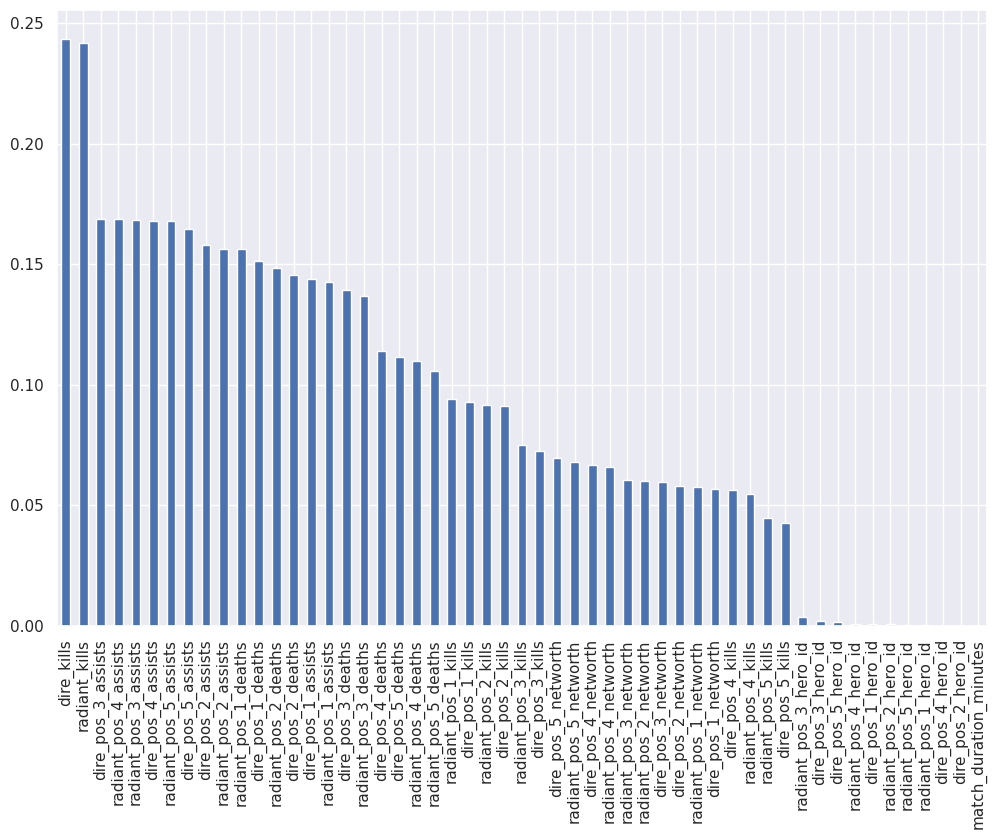

In [214]:
plot_gain_desc(mutual_info)

In [228]:
def select_k_best(X_train, y_train, X_test, k=25):
    sel_5_feats = SelectKBest(mutual_info_classif, k=k)
    sel_5_feats.fit(X_train, y_train)
    
    selected_cols = X_train.columns[sel_5_feats.get_support()]
    return X_train[selected_cols], X_test[selected_cols], selected_cols

In [231]:
X_train_selected, X_test_selected, selected_cols = select_k_best(X_train, y_train, X_test, k=52)

## Dimensionality Reduction

Now that we have chosen top 25 features based on Information Gain, we can further reduce the dimensionality using *`Principal Component Analysis (PCA)`*

#### Standard Scaling

In [232]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


#### PCA

In [233]:
from sklearn.decomposition import PCA

def decompose(X_train_scaled, X_test_scaled):
    
    pca = PCA(n_components=2)

    pca.fit(X_train_scaled)

    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    return X_train_pca, X_test_pca

In [234]:
X_train_pca, X_test_pca = decompose(X_train_scaled, X_test_scaled)

#### Naive Bayes Classifier vs Linear Discriminant Analysis

In [235]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV


def print_results(model_name, results):
    print(f'BEST PARAMS FOR {model_name}: {results.best_params_}\n')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
    print()

def get_best_model(model_name, clf, params, cv=5):
    
    grid = GridSearchCV(clf, params, cv=cv)
    if model_name == 'GaussianNB':
        grid.fit(X_train_pca, y_train)
    else:
        grid.fit(X_train_scaled, y_train)
        
    print_results(model_name, grid)
    
    return grid.best_estimator_



def get_scores(models):
    
    for model_name in models:
        
        model = models[model_name]

        if model_name == 'GaussianNB':

            y_pred = model.predict(X_test_pca)
            y_pred_prob = model.predict_proba(X_test_pca)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
        else:
            y_pred = model.predict(X_test_scaled)
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        
        roc_auc = auc(fpr, tpr)
        scores = {
            "accuracy":accuracy_score(y_test,y_pred),
            "precision":precision_score(y_test,y_pred),
            "recall":recall_score(y_test, y_pred),
            "f1_score":f1_score(y_test,y_pred),
            "roc_auc_score":roc_auc
        }
        print('-'*10 + f'{model_name}' + '-'*10)
        for score in scores:
            print(f'{score} : {scores[score]}')


        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')  
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    

In [236]:
models = {}
nb = GaussianNB()
lda = LinearDiscriminantAnalysis()
nb_params = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
lda_params = {
    'solver': ['lsqr'],
    'shrinkage': [None, 'auto']
}

models['GaussianNB'] = get_best_model('GaussianNB', nb, nb_params)
models['LDA'] = get_best_model('LDA', lda, lda_params)

BEST PARAMS FOR GaussianNB: {'var_smoothing': 1e-09}

0.954 (+/-0.003) for {'var_smoothing': 1e-09}
0.954 (+/-0.003) for {'var_smoothing': 1e-08}
0.954 (+/-0.003) for {'var_smoothing': 1e-07}

BEST PARAMS FOR LDA: {'shrinkage': None, 'solver': 'lsqr'}

0.988 (+/-0.001) for {'shrinkage': None, 'solver': 'lsqr'}
0.988 (+/-0.0) for {'shrinkage': 'auto', 'solver': 'lsqr'}



----------GaussianNB----------
accuracy : 0.9516773677831928
precision : 0.9500925164473685
recall : 0.9534247988446461
f1_score : 0.9517557409123674
roc_auc_score : 0.9894832830841457


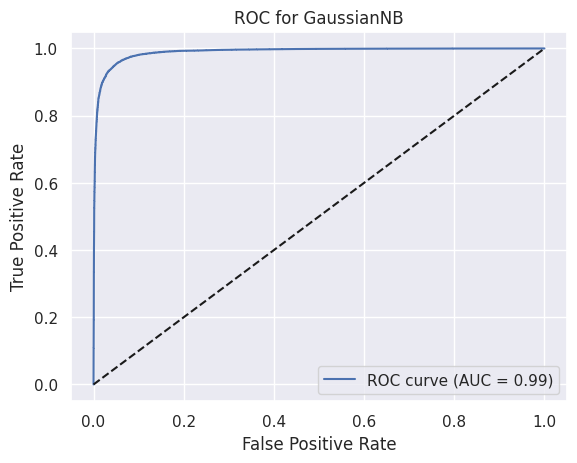

----------LDA----------
accuracy : 0.9867203011784121
precision : 0.9861919727961255
recall : 0.987260160924283
f1_score : 0.9867257777663221
roc_auc_score : 0.9867203707730785


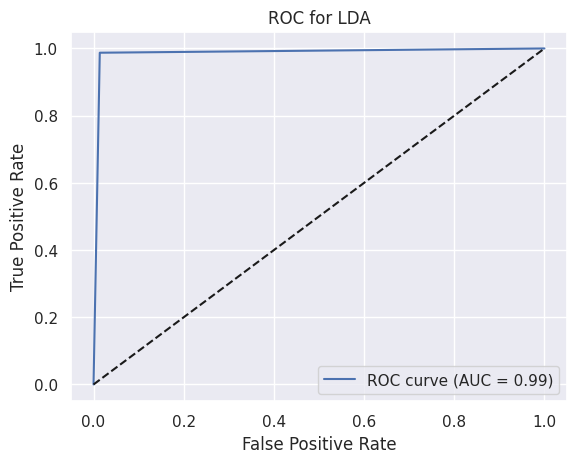

In [237]:
get_scores(models)

## Game outcome prediction at different time frames

In [238]:
maps = np.vstack((matches['radiant_player_1_hero'].T, matches['radiant_player_1_hero_id'].T)).T

id_to_hero = {}
hero_to_id = {}

for pair in maps:
    hero_to_id[pair[0]]=pair[1]
    id_to_hero[pair[1]] = pair[0] 

In [239]:
 def predict_outcome(rad_heroes, dire_heroes):
    datapoint = {'first_blood_time_seconds':240,
                 'radiant_kills' : 0, 
                 'dire_kills': 0,
                 'match_duration_minutes':0,
                 'radiant_pos_1_hero_id': hero_to_id['Io'],
                 'radiant_pos_1_kills': 1.45,
                 'radiant_pos_1_deaths': 10.27,
                 'radiant_pos_1_assists': 25.82,
                 'radiant_pos_1_networth': 14948.18,
                 'radiant_pos_2_hero_id': hero_to_id['Riki'],
                 'radiant_pos_2_kills': 2.69,
                 'radiant_pos_2_deaths': 11.85,
                 'radiant_pos_2_assists': 36.62,
                 'radiant_pos_2_networth': 15097.69,
                 'radiant_pos_3_hero_id': hero_to_id['Bane'],
                 'radiant_pos_3_kills': 3.94,
                 'radiant_pos_3_deaths': 14.06,
                 'radiant_pos_3_assists': 25.19,
                 'radiant_pos_3_networth': 15907.75,
                 'radiant_pos_4_hero_id': hero_to_id['Tusk'],
                 'radiant_pos_4_kills': 2.85,
                 'radiant_pos_4_deaths': 15.32,
                 'radiant_pos_4_assists': 24.71,
                 'radiant_pos_4_networth': 16305.97,
                 'radiant_pos_5_hero_id': hero_to_id['Oracle'],
                 'radiant_pos_5_kills': 3.95,
                 'radiant_pos_5_deaths': 9.00,
                 'radiant_pos_5_assists': 23.00,
                 'radiant_pos_5_networth': 16328.42,
                 'dire_pos_1_hero_id': hero_to_id['Arc Warden'],
                 'dire_pos_1_kills': 11.3,
                 'dire_pos_1_deaths': 6.6,
                 'dire_pos_1_assists': 12.3,
                 'dire_pos_1_networth': 50494.9,
                 'dire_pos_2_hero_id': hero_to_id['Medusa'],
                 'dire_pos_2_kills': 9.68,
                 'dire_pos_2_deaths': 4.8,
                 'dire_pos_2_assists': 15.64,
                 'dire_pos_2_networth': 50757.05,
                 'dire_pos_3_hero_id': hero_to_id['Naga Siren'],
                 'dire_pos_3_kills': 7.68,
                 'dire_pos_3_deaths': 4.94,
                 'dire_pos_3_assists': 14.3,
                 'dire_pos_3_networth': 51436.8,
                 'dire_pos_4_hero_id': hero_to_id['Anti-Mage'],
                 'dire_pos_4_kills': 15.47,
                 'dire_pos_4_deaths': 4.84,
                 'dire_pos_4_assists': 14.11,
                 'dire_pos_4_networth': 51788.42,
                 'dire_pos_5_hero_id': hero_to_id["Nature's Prophet"],
                 'dire_pos_5_kills': 14.09,
                 'dire_pos_5_deaths': 6,
                 'dire_pos_5_assists': 16.18,
                 'dire_pos_5_networth': 52334.64,
    }
    
    for key,val in datapoint.items():
        datapoint[key]=[val]

    datapoint = pd.DataFrame(datapoint)
    
    dire_kill_sum = 0
    radiant_kill_sum = 0
    for i in range(1,6):
            colstrr = f'radiant_pos_{i}_kills'
            colstrd = f'dire_pos_{i}_kills'
            radiant_kill_sum += datapoint[colstrr]
            dire_kill_sum += datapoint[colstrd]
    
    datapoint['radiant_kills']=radiant_kill_sum
    datapoint['dire_kills']=dire_kill_sum
    datapoint = datapoint[selected_cols]
    
    

    Xs = scaler.fit_transform(X_train_selected)
    datapoint = scaler.transform(datapoint)



    test_model = models['LDA']



    prediction = test_model.predict_proba(datapoint)
    
    rad_win_chance = round(prediction[0][1]*100,2)
    dire_win_chance = round(prediction[0][0]*100,2)
    
    print(f'Radiant Win : {rad_win_chance}%\nDire Win : {dire_win_chance}')
    print('-'*20)
    if rad_win_chance>dire_win_chance:
        print('So, Radiant will most likely win')
    else:
        print('So, Dire will most likely win')


In [240]:
rad_heroes = ['IO','Riki', 'Bane', 'Tusk','Oracle']
dir_heroes = ['Arc Warden', 'Medusa', 'Naga Siren', 'Anti-Mage', "Nature's Prophet"]

predict_outcome(rad_heroes, dir_heroes)

Radiant Win : 0.0%
Dire Win : 100.0
--------------------
So, Dire will most likely win


In [243]:
ndf = pd.read_parquet("/kaggle/input/dota2_matches.parquet")
print(len(ndf))
ndf = ndf.dropna()
print(len(ndf))

ndf = ndf[ndf['match_start_date_time'] > "2022-12-31"]
print(len(ndf))

177378
54236
34526


In [245]:
first_df = ndf[ndf['match_duration_seconds'] < 1201]
second_df = ndf[(ndf['match_duration_seconds'] > 1200) & (ndf['match_duration_seconds'] < 1801)]
third_df = ndf[(ndf['match_duration_seconds'] > 1800) & (ndf['match_duration_seconds'] < 2401)]
fourth_df = ndf[(ndf['match_duration_seconds'] > 2400) & (ndf['match_duration_seconds'] < 3001)]
fifth_df = ndf[(ndf['match_duration_seconds'] > 3000) & (ndf['match_duration_seconds'] < 3601)]
sixth_df = ndf[ndf['match_duration_seconds'] > 3600]

In [246]:
cols_list = []
txt1 = "{side}_player_{order}_hero"
txt2 = "{side}_player_{order}_kills"
txt3 = "{side}_player_{order}_deaths"
txt4 = "{side}_player_{order}_assists"
txt5 = "{side}_player_{order}_networth"
txt6 = "{side}_player_{order}_position"

sides = ['radiant', 'dire']
orders = range(1,6)
txt_list = [txt1, txt2, txt3, txt4, txt5, txt6]

for k in range(6):
    for j in range(len(sides)):
        for i in range(len(orders)):
            cols_list.append(txt_list[k].format(side = sides[j], order = orders[i]))

In [247]:
df_array = [first_df, second_df, third_df, fourth_df, fifth_df, sixth_df]

count_df_1 = pd.DataFrame()
count_df_2 = pd.DataFrame()
count_df_3 = pd.DataFrame()
count_df_4 = pd.DataFrame()
count_df_5 = pd.DataFrame()
count_df_6 = pd.DataFrame()

count_df_array = [count_df_1, count_df_2, count_df_3, count_df_4, count_df_5, count_df_6]

for i in range(len(df_array)):
    df_array[i] = df_array[i][cols_list]
    count_1 = df_array[i][["radiant_player_1_hero", "radiant_player_1_position"]].value_counts(ascending=False)
    count_2 = df_array[i][["radiant_player_2_hero", "radiant_player_2_position"]].value_counts(ascending=False)
    count_3 = df_array[i][["radiant_player_3_hero", "radiant_player_3_position"]].value_counts(ascending=False)
    count_4 = df_array[i][["radiant_player_4_hero", "radiant_player_4_position"]].value_counts(ascending=False)
    count_5 = df_array[i][["radiant_player_5_hero", "radiant_player_5_position"]].value_counts(ascending=False)

    count_6 = df_array[i][["dire_player_1_hero", "dire_player_1_position"]].value_counts(ascending=False)
    count_7 = df_array[i][["dire_player_2_hero", "dire_player_2_position"]].value_counts(ascending=False)
    count_8 = df_array[i][["dire_player_3_hero", "dire_player_3_position"]].value_counts(ascending=False)
    count_9 = df_array[i][["dire_player_4_hero", "dire_player_4_position"]].value_counts(ascending=False)
    count_10 = df_array[i][["dire_player_5_hero", "dire_player_5_position"]].value_counts(ascending=False)
    
    count_df_array[i] = pd.concat([count_1, count_2, count_3, count_4, count_5, count_6, count_7, count_8
                    , count_9, count_10], axis=1)

    count_df_array[i]['Total']= count_df_array[i].sum(axis=1)
    count_df_array[i] = count_df_array[i].sort_values('Total', ascending = False)
    count_df_array[i]['Total']
    
count_df_array[2]['Total']

Rubick             POSITION_4    3710.0
Crystal Maiden     POSITION_5    2412.0
Ember Spirit       POSITION_2    2339.0
Pangolier          POSITION_2    1801.0
Centaur Warrunner  POSITION_3    1693.0
                                  ...  
Dark Seer          POSITION_5       1.0
Disruptor          POSITION_3       1.0
Puck               POSITION_5       1.0
Lycan              POSITION_4       1.0
Mars               POSITION_5       1.0
Name: Total, Length: 592, dtype: float64

In [248]:
txt1 = "{side}_player_{order}_hero"
txt2 = "{side}_player_{order}_kills"
txt3 = "{side}_player_{order}_deaths"
txt4 = "{side}_player_{order}_assists"
txt5 = "{side}_player_{order}_networth"
txt6 = "{side}_player_{order}_position"


sides = ['radiant', 'dire']
orders = range(1,6)
txt_list = [txt1, txt2, txt3, txt4, txt5]

heroes_str_list = []
stats_str_list_old = []

for i in range(len(sides)):
    for j in range(len(orders)):
        s1 = txt1.format(side = sides[i], order = orders[j])
        s2 = txt6.format(side = sides[i], order = orders[j])
        heroes_str_list.append([s1, s2])

for k in range(len(orders)):
    for j in range(len(sides)):
        hehe_list = []
        for i in range(1, 5):
            hehe_list.append(txt_list[i].format(side = sides[j], order = orders[k]))
        stats_str_list_old.append(hehe_list)

stats_str_list = []

for i in range(2):
    for j in range(5):
        stats_str_list.append(stats_str_list_old[i + 2*j])

stats_str_list

[['radiant_player_1_kills',
  'radiant_player_1_deaths',
  'radiant_player_1_assists',
  'radiant_player_1_networth'],
 ['radiant_player_2_kills',
  'radiant_player_2_deaths',
  'radiant_player_2_assists',
  'radiant_player_2_networth'],
 ['radiant_player_3_kills',
  'radiant_player_3_deaths',
  'radiant_player_3_assists',
  'radiant_player_3_networth'],
 ['radiant_player_4_kills',
  'radiant_player_4_deaths',
  'radiant_player_4_assists',
  'radiant_player_4_networth'],
 ['radiant_player_5_kills',
  'radiant_player_5_deaths',
  'radiant_player_5_assists',
  'radiant_player_5_networth'],
 ['dire_player_1_kills',
  'dire_player_1_deaths',
  'dire_player_1_assists',
  'dire_player_1_networth'],
 ['dire_player_2_kills',
  'dire_player_2_deaths',
  'dire_player_2_assists',
  'dire_player_2_networth'],
 ['dire_player_3_kills',
  'dire_player_3_deaths',
  'dire_player_3_assists',
  'dire_player_3_networth'],
 ['dire_player_4_kills',
  'dire_player_4_deaths',
  'dire_player_4_assists',
  'dir

In [249]:
df_list_1 = []
df_list_2 = []
df_list_3 = []
df_list_4 = []
df_list_5 = []
df_list_6 = []

df_list_array = [df_list_1, df_list_2, df_list_3, df_list_4, df_list_5, df_list_6]
for j in range(len(df_array)):
    for i in range(10):
        hehe_df = []
        hehe_df = df_array[j].groupby(heroes_str_list[i]).sum()
        hehe_df = hehe_df[stats_str_list[i]]
#         hehe_df['hero_and_position'] = hehe_df.index
#         hehe_df.set_index('hero_and_position', inplace=True)
        
        hehe_df = hehe_df.rename_axis(['hero','pos'])
        df_list_array[j].append(hehe_df)

In [250]:
print(df_list_array[0][0].index)
print(df_list_array[0][1].index)

MultiIndex([(           'Abaddon', 'POSITION_1'),
            (           'Abaddon', 'POSITION_3'),
            (           'Abaddon', 'POSITION_5'),
            (         'Alchemist', 'POSITION_1'),
            (         'Alchemist', 'POSITION_2'),
            (         'Alchemist', 'POSITION_3'),
            (         'Alchemist', 'POSITION_4'),
            ('Ancient Apparition', 'POSITION_4'),
            ('Ancient Apparition', 'POSITION_5'),
            (         'Anti-Mage', 'POSITION_1'),
            ...
            (        'Windranger', 'POSITION_5'),
            (     'Winter Wyvern', 'POSITION_2'),
            (     'Winter Wyvern', 'POSITION_3'),
            (     'Winter Wyvern', 'POSITION_4'),
            (     'Winter Wyvern', 'POSITION_5'),
            (      'Witch Doctor', 'POSITION_2'),
            (      'Witch Doctor', 'POSITION_5'),
            (       'Wraith King', 'POSITION_1'),
            (       'Wraith King', 'POSITION_3'),
            (              'Zeus',

In [251]:
total_kils_df_1 = pd.DataFrame()
total_kils_df_2 = pd.DataFrame()
total_kils_df_3 = pd.DataFrame()
total_kils_df_4 = pd.DataFrame()
total_kils_df_5 = pd.DataFrame()
total_kils_df_6 = pd.DataFrame()

total_kills_df_array = [total_kils_df_1, total_kils_df_2, total_kils_df_3, total_kils_df_4, total_kils_df_5, total_kils_df_6]

for i in range(len(total_kills_df_array)):
    total_kills_df_array[i] = pd.merge(df_list_array[i][0], df_list_array[i][1], left_index=True, right_index=True, how = "outer").fillna(0)
    for j in range(2, len(df_list_array[i])):
        total_kills_df_array[i] = pd.merge(total_kills_df_array[i], df_list_array[i][j], left_index=True, right_index=True, how = "outer").fillna(0)

In [252]:
kills_str_list = []
assists_str_list = []
deaths_str_list = []
networth_str_list = []

for i in range(len(sides)):
    for j in range(len(orders)):
        kills_str_list.append(txt2.format(side = sides[i], order = orders[j]))

for i in range(len(sides)):
    for j in range(len(orders)):
        assists_str_list.append(txt4.format(side = sides[i], order = orders[j]))

for i in range(len(sides)):
    for j in range(len(orders)):
        deaths_str_list.append(txt3.format(side = sides[i], order = orders[j]))

for i in range(len(sides)):
    for j in range(len(orders)):
        networth_str_list.append(txt5.format(side = sides[i], order = orders[j]))

In [253]:
for i in range(len(df_array)):
    total_kills_df_array[i]['total_kills'] =  total_kills_df_array[i][kills_str_list].sum(axis=1)
    total_kills_df_array[i]['total_assists'] = total_kills_df_array[i][assists_str_list].sum(axis=1)
    total_kills_df_array[i]['total_deaths'] = total_kills_df_array[i][deaths_str_list].sum(axis=1)
    total_kills_df_array[i]['total_networth'] = total_kills_df_array[i][networth_str_list].sum(axis=1)
    df_array[i] = total_kills_df_array[i][["total_kills", "total_assists", "total_deaths", "total_networth"]]

In [254]:
pd.options.mode.chained_assignment = None

for i in range(len(df_array)):
    df_array[i]['total_kills'] = df_array[i]['total_kills'].astype(float)
    df_array[i]['total_assists'] = df_array[i]['total_assists'].astype(float)
    df_array[i]['total_deaths'] = df_array[i]['total_deaths'].astype(float)
    df_array[i]['total_networth'] = df_array[i]['total_networth'].astype(float)
    
df_array[2].tail(50)

total_kills  total_assists  total_deaths  \
hero          pos                                                    
Venomancer    POSITION_4        489.0         2240.0        1159.0   
              POSITION_5        961.0         5606.0        2970.0   
Viper         POSITION_1        383.0          484.0         233.0   
              POSITION_2       1271.0         1948.0        1062.0   
              POSITION_3       1619.0         2907.0        1770.0   
              POSITION_4        107.0          183.0         168.0   
              POSITION_5         35.0           94.0          82.0   
Visage        POSITION_1         97.0          135.0          61.0   
              POSITION_2        299.0          378.0         174.0   
              POSITION_3       1636.0         3010.0        1294.0   
              POSITION_4        339.0          948.0         437.0   
              POSITION_5        293.0          798.0         395.0   
Void Spirit   POSITION_1        704.0          751.0         276.0   
              POSITION_2       8032.0         9106.0        4300.0   
              POSITION_3        370.0          485.0         260.0   
              POSITION_4        177.0          290.0         148.0   
              POSITION_5         11.0           36.0          18.0   
Warlock       POSITION_2          7.0           17.0          12.0   
              POSITION_3          8.0           12.0           6.0   
              POSITION_4        148.0          610.0         296.0   
              POSITION_5       1854.0         8448.0        3896.0   
Weaver        POSITION_1       5942.0         5979.0        2561.0   
              POSITION_2        128.0          109.0          69.0   
              POSITION_3        384.0          499.0         230.0   
              POSITION_4       1173.0         2859.0        1343.0   
              POSITION_5        193.0          518.0         321.0   
Windranger    POSITION_1       3106.0         3370.0        1520.0   
              POSITION_2       7181.0         7966.0        3832.0   
              POSITION_3       4128.0         5176.0        2975.0   
              POSITION_4       1509.0         4201.0        2099.0   
              POSITION_5        607.0         1841.0         930.0   
Winter Wyvern POSITION_1         81.0          149.0          84.0   
              POSITION_2        591.0         1089.0         583.0   
              POSITION_3        465.0          913.0         496.0   
              POSITION_4        704.0         2840.0        1609.0   
              POSITION_5        449.0         2388.0        1401.0   
Witch Doctor  POSITION_1         13.0           38.0          19.0   
              POSITION_2        472.0          503.0         254.0   
              POSITION_3        129.0          219.0         164.0   
              POSITION_4       1031.0         1956.0        1571.0   
              POSITION_5       2574.0         5489.0        4289.0   
Wraith King   POSITION_1       3998.0         5152.0        2164.0   
              POSITION_2         18.0           28.0          14.0   
              POSITION_3       1424.0         2995.0        1275.0   
              POSITION_4         10.0           41.0          25.0   
Zeus          POSITION_1        111.0          102.0          48.0   
              POSITION_2      10062.0        13729.0        5150.0   
              POSITION_3        124.0          182.0          90.0   
              POSITION_4       1120.0         2401.0        1043.0   
              POSITION_5        449.0         1023.0         490.0   

                          total_networth  
hero          pos                         
Venomancer    POSITION_4       1482310.0  
              POSITION_5       3563520.0  
Viper         POSITION_1        761727.0  
              POSITION_2       3254452.0  
              POSITION_3       3758565.0  
              POSITION_4        205337.0  
              POSITION_5         60896.0 

In [255]:
for i in range(len(df_array)):
    index_list = df_array[i].index.tolist()
    for j in index_list:
        cnt = count_df_array[i]['Total'].loc[[j]]
        if(cnt.iloc[0] < 10):
            df_array[i] = df_array[i].drop(j)
        else:
            df_array[i].loc[[j], 'total_kills'] = round(df_array[i].loc[[j], 'total_kills'] / cnt.iloc[0], 2)
            df_array[i].loc[[j], 'total_assists'] = round(df_array[i].loc[[j], 'total_assists'] / cnt.iloc[0], 2)
            df_array[i].loc[[j], 'total_deaths'] = round(df_array[i].loc[[j], 'total_deaths'] / cnt.iloc[0], 2)
            df_array[i].loc[[j], 'total_networth'] = round(df_array[i].loc[[j], 'total_networth'] / cnt.iloc[0], 2)

In [256]:
hehesiu_df = df_array[3].sort_values(by=['total_networth'])
hehesiu_df

,,total_kills,total_assists,total_deaths,total_networth
hero,pos,,,,
Sven,POSITION_5,1.79,19.07,9.36,8622.64
Omniknight,POSITION_5,1.68,16.32,7.41,8736.59
Riki,POSITION_4,2.56,24.03,7.71,9277.90
Bane,POSITION_5,2.77,15.47,10.16,9487.68
Riki,POSITION_5,2.24,22.71,9.05,9649.10
...,...,...,...,...,...
Terrorblade,POSITION_1,8.16,9.72,4.15,31610.18
Anti-Mage,POSITION_1,9.92,9.11,4.36,31817.89
Alchemist,POSITION_1,8.03,13.42,4.66,32236.61


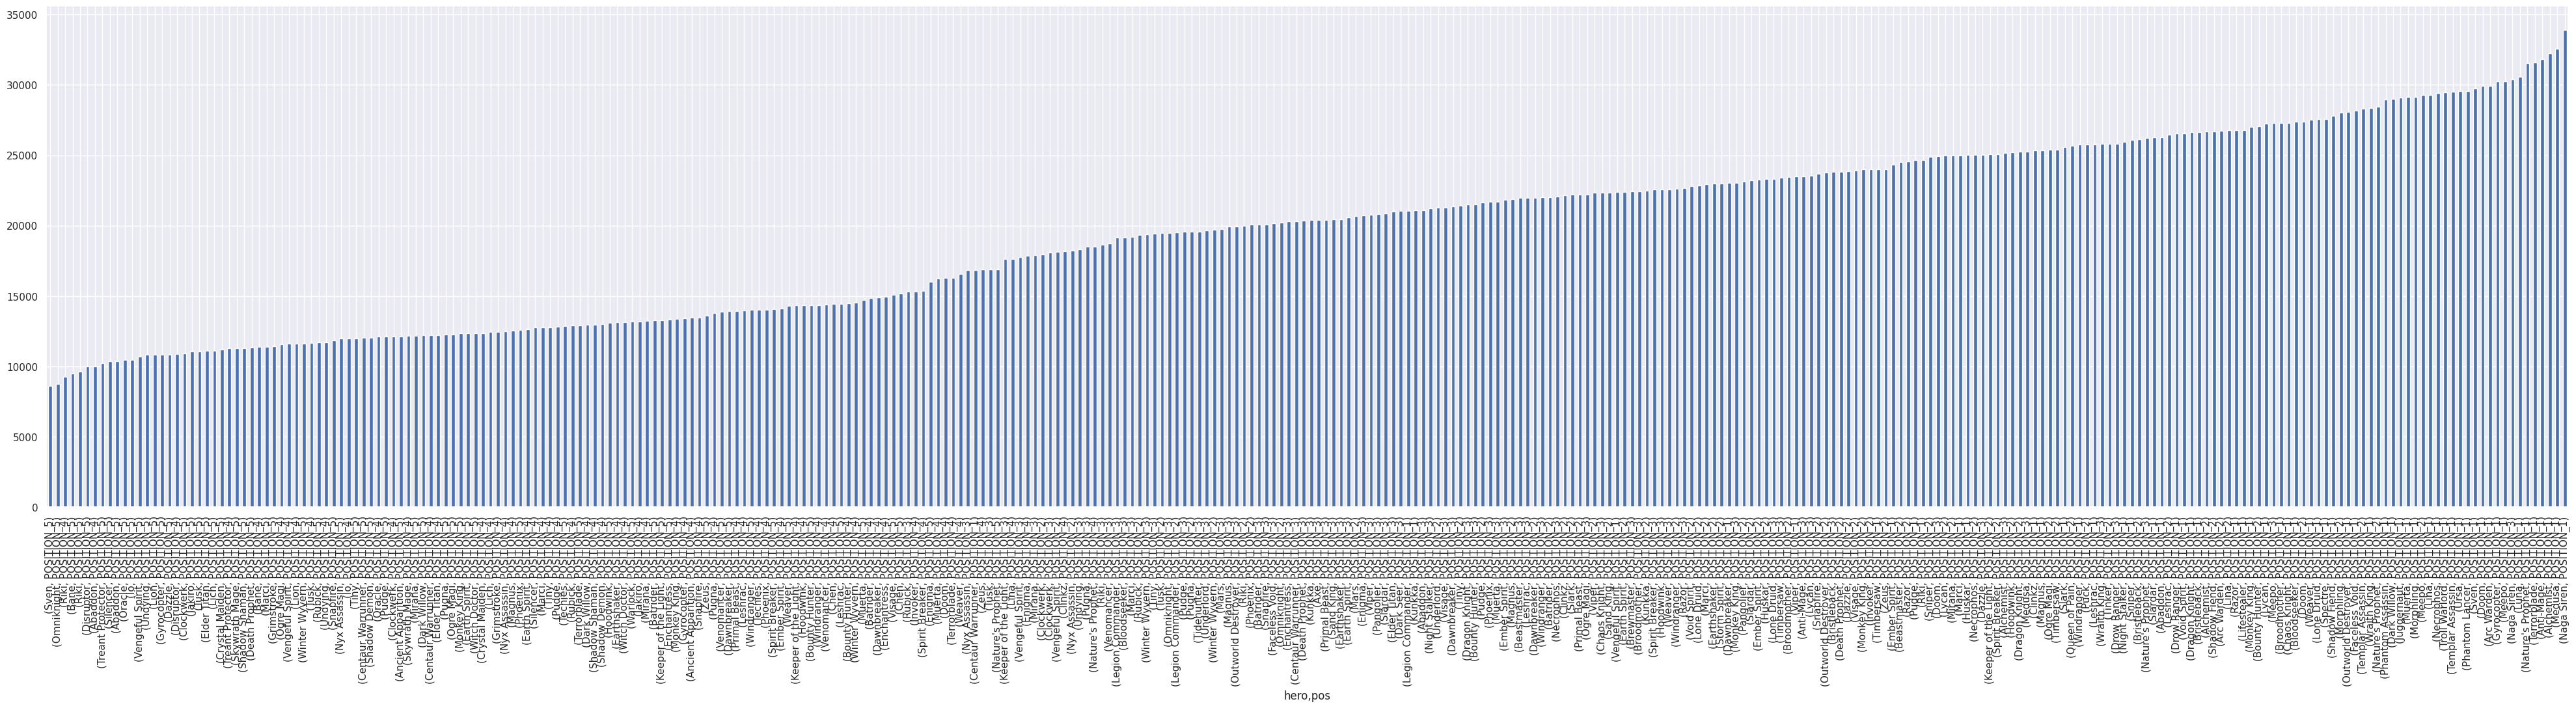

In [260]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50,10))
hehesiu_df['total_networth'].plot.bar()

plt.show()

In [258]:
# hehesiu_df[[hehesiu_df.index[1] == 'POSITION_5']].total_networth.mean()

hehesiu_df[hehesiu_df.index.isin(['POSITION_5'], level=1)].mean().tolist()

hehesiu_df.loc[('Sven', 'POSITION_5')]

total_kills          1.79
total_assists       19.07
total_deaths         9.36
total_networth    8622.64
Name: (Sven, POSITION_5), dtype: float64

In [261]:
txt1 = "{side}_pos_{order}_hero_id"
txt2 = "{side}_pos_{order}_kills"
txt3 = "{side}_pos_{order}_assists"
txt4 = "{side}_pos_{order}_deaths"
txt5 = "{side}_pos_{order}_networth"


sides = ['radiant', 'dire']
orders = range(1,6)
txt_list = [txt1, txt2, txt3, txt4, txt5]

In [262]:
duration = [
    [0, 20],
    [20, 30],
    [30, 40],
    [40, 50],
    [50, 60],
    [60, 'infinity']
]

In [263]:
def predict_outcome_at_different_time(rad_heroes, dire_heroes):
    
    for i in range(5):
        heroes_stats = []
        for j in range(5):
            pos = 'POSITION_{}'.format(j+1)
            arr = df_array[i]
            if((rad_heroes[j], pos) in arr.index.tolist()):
                heroes_stats.append(arr.loc[(rad_heroes[j], pos)].tolist())
            else:
                heroes_stats.append(arr[arr.index.isin([pos], level=1)].mean().tolist())
                
            if((dire_heroes[j], pos) in arr.index.tolist()):
                heroes_stats.append(arr.loc[(dire_heroes[j], pos)].tolist())
            else:
                heroes_stats.append(arr[arr.index.isin([pos], level=1)].mean().tolist())
                
        datapoint = {'first_blood_time_seconds':240,
                     'radiant_kills' : 0, 
                     'dire_kills': 0,
                     'match_duration_minutes':0,
                    }
        
        for j in range(5): #j - order
            for k in range(5): #k - txt_list
                if (k == 0):
                    datapoint[txt_list[k].format(side = sides[0], order = orders[j])] = hero_to_id[rad_heroes[j]]
                    datapoint[txt_list[k].format(side = sides[1], order = orders[j])] = hero_to_id[dire_heroes[j]]
                else:
                    datapoint[txt_list[k].format(side = sides[0], order = orders[j])] = heroes_stats[2*k - 2][k - 1]
                    datapoint[txt_list[k].format(side = sides[1], order = orders[j])] = heroes_stats[2*k - 1][k - 1]
    
        for key,val in datapoint.items():
            datapoint[key]=[val]

        datapoint = pd.DataFrame(datapoint)
    
        dire_kill_sum = 0
        radiant_kill_sum = 0
        for d in range(1,6):
            colstrr = f'radiant_pos_{d}_kills'
            colstrd = f'dire_pos_{d}_kills'
            radiant_kill_sum += datapoint[colstrr]
            dire_kill_sum += datapoint[colstrd]
    
        datapoint['radiant_kills']=radiant_kill_sum
        datapoint['dire_kills']=dire_kill_sum
        datapoint = datapoint[selected_cols]
    
    

        Xs = scaler.fit_transform(X_train_selected)
        datapoint = scaler.transform(datapoint)



        test_model = models['LDA']



        prediction = test_model.predict_proba(datapoint)
    
        rad_win_chance = round(prediction[0][1]*100,2)
        dire_win_chance = round(prediction[0][0]*100,2)
        
        print(f'For interval {duration[i][0]} to {duration[i][1]} minutes:')
        print(f'Radiant Win : {rad_win_chance}%\nDire Win : {dire_win_chance}')
        
        if rad_win_chance>dire_win_chance:
            print('So, Radiant will most likely win')
        else:
            print('So, Dire will most likely win')
            
        print('-'*20)


In [266]:
rad_heroes = ['Luna','Kunkka', 'Tidehunter', 'Enchantress','Pugna']
dir_heroes = ['Razor', 'Pangolier', 'Lone Druid', 'Muerta', "Phoenix"]

predict_outcome_at_different_time(rad_heroes, dir_heroes)

For interval 0 to 20 minutes:
Radiant Win : 63.24%
Dire Win : 36.76
So, Radiant will most likely win
--------------------
For interval 20 to 30 minutes:
Radiant Win : 29.31%
Dire Win : 70.69
So, Dire will most likely win
--------------------
For interval 30 to 40 minutes:
Radiant Win : 24.78%
Dire Win : 75.22
So, Dire will most likely win
--------------------
For interval 40 to 50 minutes:
Radiant Win : 10.7%
Dire Win : 89.3
So, Dire will most likely win
--------------------
For interval 50 to 60 minutes:
Radiant Win : 1.34%
Dire Win : 98.66
So, Dire will most likely win
--------------------


In [267]:
dir_heroes = ['Luna','Kunkka', 'Tidehunter', 'Enchantress','Pugna']
rad_heroes = ['Razor', 'Pangolier', 'Lone Druid', 'Muerta', "Phoenix"]

predict_outcome_at_different_time(rad_heroes, dir_heroes)

For interval 0 to 20 minutes:
Radiant Win : 34.52%
Dire Win : 65.48
So, Dire will most likely win
--------------------
For interval 20 to 30 minutes:
Radiant Win : 67.15%
Dire Win : 32.85
So, Radiant will most likely win
--------------------
For interval 30 to 40 minutes:
Radiant Win : 70.53%
Dire Win : 29.47
So, Radiant will most likely win
--------------------
For interval 40 to 50 minutes:
Radiant Win : 85.77%
Dire Win : 14.23
So, Radiant will most likely win
--------------------
For interval 50 to 60 minutes:
Radiant Win : 98.05%
Dire Win : 1.95
So, Radiant will most likely win
--------------------


In [268]:
rad_heroes = ['Luna','Invoker', 'Tidehunter', 'Enchantress','Pugna']
dir_heroes = ['Razor', 'Pangolier', 'Lone Druid', 'Muerta', "Phoenix"]

predict_outcome_at_different_time(rad_heroes, dir_heroes)

For interval 0 to 20 minutes:
Radiant Win : 61.62%
Dire Win : 38.38
So, Radiant will most likely win
--------------------
For interval 20 to 30 minutes:
Radiant Win : 25.02%
Dire Win : 74.98
So, Dire will most likely win
--------------------
For interval 30 to 40 minutes:
Radiant Win : 20.62%
Dire Win : 79.38
So, Dire will most likely win
--------------------
For interval 40 to 50 minutes:
Radiant Win : 5.64%
Dire Win : 94.36
So, Dire will most likely win
--------------------
For interval 50 to 60 minutes:
Radiant Win : 0.72%
Dire Win : 99.28
So, Dire will most likely win
--------------------


In [269]:
dir_heroes = ['Luna','Invoker', 'Tidehunter', 'Enchantress','Pugna']
rad_heroes = ['Razor', 'Pangolier', 'Lone Druid', 'Muerta', "Phoenix"]

predict_outcome_at_different_time(rad_heroes, dir_heroes)

For interval 0 to 20 minutes:
Radiant Win : 36.16%
Dire Win : 63.84
So, Dire will most likely win
--------------------
For interval 20 to 30 minutes:
Radiant Win : 71.83%
Dire Win : 28.17
So, Radiant will most likely win
--------------------
For interval 30 to 40 minutes:
Radiant Win : 75.29%
Dire Win : 24.71
So, Radiant will most likely win
--------------------
For interval 40 to 50 minutes:
Radiant Win : 92.41%
Dire Win : 7.59
So, Radiant will most likely win
--------------------
For interval 50 to 60 minutes:
Radiant Win : 98.96%
Dire Win : 1.04
So, Radiant will most likely win
--------------------


In [271]:
rad_heroes = ['Luna','Invoker', 'Kunkka', 'Weaver','Pugna']
dir_heroes = ['Bloodseeker', 'Necrophos', 'Centaur Warrunner', 'Muerta', "Phoenix"]

predict_outcome_at_different_time(rad_heroes, dir_heroes)

For interval 0 to 20 minutes:
Radiant Win : 55.94%
Dire Win : 44.06
So, Radiant will most likely win
--------------------
For interval 20 to 30 minutes:
Radiant Win : 46.08%
Dire Win : 53.92
So, Dire will most likely win
--------------------
For interval 30 to 40 minutes:
Radiant Win : 40.04%
Dire Win : 59.96
So, Dire will most likely win
--------------------
For interval 40 to 50 minutes:
Radiant Win : 60.36%
Dire Win : 39.64
So, Radiant will most likely win
--------------------
For interval 50 to 60 minutes:
Radiant Win : 38.06%
Dire Win : 61.94
So, Dire will most likely win
--------------------


In [272]:
dir_heroes = ['Luna','Invoker', 'Kunkka', 'Weaver','Pugna']
rad_heroes = ['Bloodseeker', 'Necrophos', 'Centaur Warrunner', 'Muerta', "Phoenix"]

predict_outcome_at_different_time(rad_heroes, dir_heroes)

For interval 0 to 20 minutes:
Radiant Win : 41.96%
Dire Win : 58.04
So, Dire will most likely win
--------------------
For interval 20 to 30 minutes:
Radiant Win : 49.9%
Dire Win : 50.1
So, Dire will most likely win
--------------------
For interval 30 to 40 minutes:
Radiant Win : 54.29%
Dire Win : 45.71
So, Radiant will most likely win
--------------------
For interval 40 to 50 minutes:
Radiant Win : 32.22%
Dire Win : 67.78
So, Dire will most likely win
--------------------
For interval 50 to 60 minutes:
Radiant Win : 52.34%
Dire Win : 47.66
So, Radiant will most likely win
--------------------


In [273]:
rad_heroes = ['Phantom Assassin','Primal Beast', 'Axe', 'Skywrath Mage','Enchantress']
dir_heroes = ['Bristleback', 'Pangolier', 'Pudge', 'Grimstroke', "Crystal Maiden"]

predict_outcome_at_different_time(rad_heroes, dir_heroes)

For interval 0 to 20 minutes:
Radiant Win : 53.4%
Dire Win : 46.6
So, Radiant will most likely win
--------------------
For interval 20 to 30 minutes:
Radiant Win : 60.9%
Dire Win : 39.1
So, Radiant will most likely win
--------------------
For interval 30 to 40 minutes:
Radiant Win : 55.08%
Dire Win : 44.92
So, Radiant will most likely win
--------------------
For interval 40 to 50 minutes:
Radiant Win : 59.74%
Dire Win : 40.26
So, Radiant will most likely win
--------------------
For interval 50 to 60 minutes:
Radiant Win : 86.45%
Dire Win : 13.55
So, Radiant will most likely win
--------------------


In [274]:
dir_heroes = ['Phantom Assassin','Primal Beast', 'Axe', 'Skywrath Mage','Enchantress']
rad_heroes = ['Bristleback', 'Pangolier', 'Pudge', 'Grimstroke', "Crystal Maiden"]

predict_outcome_at_different_time(rad_heroes, dir_heroes)

For interval 0 to 20 minutes:
Radiant Win : 46.48%
Dire Win : 53.52
So, Dire will most likely win
--------------------
For interval 20 to 30 minutes:
Radiant Win : 37.53%
Dire Win : 62.47
So, Dire will most likely win
--------------------
For interval 30 to 40 minutes:
Radiant Win : 42.12%
Dire Win : 57.88
So, Dire will most likely win
--------------------
For interval 40 to 50 minutes:
Radiant Win : 36.24%
Dire Win : 63.76
So, Dire will most likely win
--------------------
For interval 50 to 60 minutes:
Radiant Win : 10.95%
Dire Win : 89.05
So, Dire will most likely win
--------------------
